In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image

!pip install git+https://github.com/openai/CLIP.git

import clip
import numpy as np

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ylk5qpru
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ylk5qpru
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=d2306e6d3b967c7d782fb22dca9013de2b762a107b2031eadc929ed8f133d791
  Stored in directory: /tmp/pip-ephem-wheel-cache-6ltk5ctw/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


### Utility Functions that load captions, preprocess images and tokenize captions ###

In [2]:
# Some utility functions are defined above

# Load captions
def load_captions(captions_file):
    captions = []
    with open(captions_file, 'r') as f:
        for line in f:
            img, caption = line.strip().split(',', 1)  # Split on the first comma
            if (img != 'image'):
                captions.append((img.strip(), caption.strip()))
    return captions


# Preprocess images using CLIP
def preprocess_images(image_folder, clip_preprocess, device):
    images = {}
    for img_name in os.listdir(image_folder):
        try:
            img_path = os.path.join(image_folder, img_name)
            image = Image.open(img_path).convert("RGB")
            image_input = clip_preprocess(image).unsqueeze(0).to(device).to(torch.float32)

            images[img_name] = image_input
        except Exception as e:
            print(f"Error with {img_name}: {e}")
    return images

# tokenizer the caption for the model
def tokenize_caption(caption, vocab, max_len=20):
    words = caption.lower().split()
    
    # include start/end tokens
    tokens = [vocab['<start>']] + [vocab.get(w, vocab['<unk>']) for w in words] + [vocab['<end>']]

    # If the sequence is longer than max_len
    if len(tokens) > max_len:
        tokens = tokens[:max_len]
        tokens[-1] = vocab['<end>']

    # If shorter, pad it
    if len(tokens) < max_len:
        tokens += [vocab['<pad>']] * (max_len - len(tokens))

    return tokens


In [3]:
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"


captions_file = "/kaggle/input/captions.txt"
image_folder = "/kaggle/input/Images"

# Load captions
captions = load_captions(captions_file)

# Preprocess images
preprocessed_images = preprocess_images(image_folder, clip.load("ViT-B/32")[1], device)


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 156MiB/s]


In [4]:
print(f"Captions Sample: {captions[:5]}")

Captions Sample: [('1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .'), ('1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'), ('1000268201_693b08cb0e.jpg', 'A little girl climbing into a wooden playhouse .'), ('1000268201_693b08cb0e.jpg', 'A little girl climbing the stairs to her playhouse .'), ('1000268201_693b08cb0e.jpg', 'A little girl in a pink dress going into a wooden cabin .')]


In [5]:
from collections import Counter

def build_vocab(captions, min_freq=1):
    word_counts = Counter()

    # Tokenize and count words
    for _, caption in captions:
        words = caption.lower().split()  # Simple split by spaces
        word_counts.update(words)
    
    # create the vocabulary with special tokens
    vocab = {"<pad>": 0, "<unk>": 1, "<start>": 2, "<end>": 3}
    index = 4

    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = index
            index += 1

    return vocab


In [6]:
vocab = build_vocab(captions, min_freq=1)
print(f"Vocabulary size: {len(vocab)}")
print(f"Words: {list(vocab.items())[:10]}")


Vocabulary size: 9184
Words: [('<pad>', 0), ('<unk>', 1), ('<start>', 2), ('<end>', 3), ('a', 4), ('child', 5), ('in', 6), ('pink', 7), ('dress', 8), ('is', 9)]


### Define a dataset for Flickr8k ###

In [7]:
# For this model, we used the Flickr8k dataset and it's loaded to Kaggle's Input

from torch.utils.data import Dataset

class FlickrDataset(Dataset):
    def __init__(self, captions, images, vocab):
        self.captions = [(img, cap) for img, cap in captions if img in images]
        self.images = images
        self.vocab = vocab

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_name, caption = self.captions[idx]
        if img_name not in self.images:
            raise ValueError(f"{img_name} not found in preprocessed images!")
        
        return img_name, torch.tensor(tokenize_caption(caption, self.vocab))


### Define a function to split the data to training set and test  set ###

In [8]:
# Spilt the dataset to training set and test set

from sklearn.model_selection import train_test_split

def split_data(captions, test_size=0.2, random_state=42):

    img_names = list(set([img for img, _ in captions]))
    train_imgs, test_imgs = train_test_split(img_names, test_size=test_size, random_state=random_state)

    train_captions = [(img, cap) for img, cap in captions if img in train_imgs]
    test_captions = [(img, cap) for img, cap in captions if img in test_imgs]

    return train_captions, test_captions


In [9]:
# Split the captions
train_captions, test_captions = split_data(captions, test_size=0.2)

train_dataset = FlickrDataset(train_captions, preprocessed_images, vocab)
test_dataset = FlickrDataset(test_captions, preprocessed_images, vocab)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


Training samples: 32360, Testing samples: 8095


### Construct the CLIP Encoder and LSTM Decoder we will be using ###

In [10]:
# Encoder we used the pretrained CLIP model "ViT-B/32"

class CLIPEncoder(nn.Module):
    def __init__(self, device):
        super(CLIPEncoder, self).__init__()
        self.device = device
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)

    def forward(self, image):
        with torch.no_grad():
            features = self.model.encode_image(image)
            features = features / features.norm(dim=-1, keepdim=True)  # Normalize
        return features.unsqueeze(1) 


In [11]:
# Include attention mechanism for the model to make better predictions

class Attention(nn.Module):
    def __init__(self, encoder_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, 512)
        self.decoder_att = nn.Linear(512, 512)
        self.full_att = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha


In [12]:
# For the decoder, we used the LSTM

class Decoder(nn.Module):
    def __init__(self, vocabulary_size, encoder_dim, tf=False):
        super(Decoder, self).__init__()
        self.use_tf = tf
        self.vocabulary_size = vocabulary_size
        self.encoder_dim = encoder_dim

        self.init_h = nn.Linear(encoder_dim, 512)
        self.init_c = nn.Linear(encoder_dim, 512)
        self.tanh = nn.Tanh()

        self.f_beta = nn.Linear(512, encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.deep_output = nn.Linear(512, vocabulary_size)
        self.dropout = nn.Dropout()

        self.attention = Attention(encoder_dim)
        self.embedding = nn.Embedding(vocabulary_size, 512)
        self.lstm = nn.LSTMCell(512 + encoder_dim, 512)

    def forward(self, img_features, captions):
        batch_size = img_features.size(0)
        max_timespan = captions.size(1) - 1

        h, c = self.get_init_lstm_state(img_features)

        embedding = self.embedding(captions)

        preds = torch.zeros(batch_size, max_timespan, self.vocabulary_size).to(img_features.device)
        alphas = torch.zeros(batch_size, max_timespan, img_features.size(1)).to(img_features.device)

        for t in range(max_timespan):
            context, alpha = self.attention(img_features, h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            lstm_input = torch.cat((embedding[:, t], gated_context), dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            preds[:, t] = self.deep_output(self.dropout(h))
            alphas[:, t] = alpha

        return preds, alphas

    def get_init_lstm_state(self, img_features):
        img_features = img_features.to(torch.float32)
        avg_features = img_features.mean(dim=1)
        c = self.tanh(self.init_c(avg_features))
        h = self.tanh(self.init_h(avg_features))
        return h, c


In [13]:
# construct the encoder decoder structure

class EncoderDecoder(nn.Module):
    def __init__(self, vocab_size, device):
        super(EncoderDecoder, self).__init__()
        self.encoder = CLIPEncoder(device)
        self.decoder = Decoder(vocab_size, encoder_dim=512)

    def forward(self, images, captions):
        encoder_out = self.encoder(images)
        preds, alphas = self.decoder(encoder_out, captions)
        return preds, alphas


### Training the Encoder Decoder model ###

In [14]:
losses = []
def train_model(model, data_loader, criterion, optimizer, vocab_size, device, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for img_names, captions in data_loader:
            valid_images = []
            for name in img_names:
                if name in preprocessed_images:
                    valid_images.append(preprocessed_images[name])
                else:
                    print(f"Skipping invalid key: {name}")

            if not valid_images:
                continue  # Skip batch if no valid images

            # Combine valid images into a tensor
            images = torch.cat(valid_images).to(device)
            captions = captions.to(device)

            # Forward pass
            preds, alphas = model(images, captions)

            max_seq_len = captions.size(1) - 1  # Exclude <end> token
            preds = preds[:, :max_seq_len, :].contiguous()
            targets = captions[:, 1:max_seq_len + 1].contiguous()

            loss = criterion(preds.view(-1, vocab_size), targets.view(-1))

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
        losses.append(total_loss/len(data_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(data_loader)}")



In [15]:
model = EncoderDecoder(len(vocab), device).to(device)
model = model.to(torch.float32)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [16]:
print(f"Vocabulary size passed to Decoder: {len(vocab)}")
print(f"Decoder's vocabulary size: {model.decoder.vocabulary_size}")


Vocabulary size passed to Decoder: 9184
Decoder's vocabulary size: 9184


In [ ]:
train_model(model, train_loader, criterion, optimizer, len(vocab), device)

Epoch 1/20, Loss: 4.2563004993167315
Epoch 2/20, Loss: 3.4385771393304756


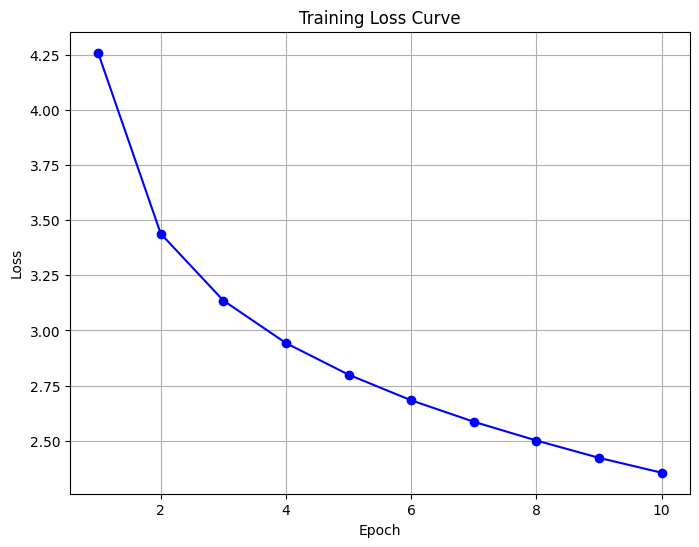

In [26]:
import matplotlib.pyplot as plt


epochs = list(range(1, 11))  # Epochs from 1 to 10
# losses = [
#     4.6180592459652265, 3.7734965309795183, 3.4776065856100544,
#     3.278049479163852, 3.1304872481248123, 3.012644949166671,
#     2.914686327395232, 2.8316029385615713, 2.7572919848879334,
#     2.69440748050575
# ]

# Plot the training loss curve
plt.figure(figsize=(8, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show() 


In [27]:
# Save the model
torch.save(model, "trained_model_full_2e^-4.pth")
print("Model saved")


Model saved


In [20]:
# Load the model
model = torch.load("trained_model_full.pth")
model.to(device)
model.eval()
print("Model loaded")


/tmp/ipykernel_23/53289200.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("trained_model_full.pth")


Model loaded


In [25]:
def beam_search_caption(model, image, vocab, device, beam_size=3, max_len=20):

    model.eval()
    idx_to_word = {v: k for k, v in vocab.items()}  # Reverse vocab for decoding

    # Encode the image using the encoder
    with torch.no_grad():
        encoder_out = model.encoder(image) 

    # Initialize the LSTM hidden states
    h, c = model.decoder.get_init_lstm_state(encoder_out)

    start_token = vocab['<start>']
    end_token = vocab['<end>']

    # Beam search initialization
    sequences = [(0.0, [start_token], h, c)]  # (cumulative log probability, sequence, hidden state, cell state)

    # Iterate over each timestep
    for _ in range(max_len):
        all_candidates = []

        for score, seq, h, c in sequences:
            # If the last token is <end>, keep the sequence as is
            if seq[-1] == end_token:
                all_candidates.append((score, seq, h, c))
                continue

            # Get the last word and embed it
            prev_word = torch.tensor([seq[-1]]).to(device)
            embedding = model.decoder.embedding(prev_word)

            # Compute attention and LSTM outputs
            context, _ = model.decoder.attention(encoder_out, h)
            gate = model.decoder.sigmoid(model.decoder.f_beta(h))
            gated_context = gate * context

            lstm_input = torch.cat((embedding, gated_context), dim=1)
            h, c = model.decoder.lstm(lstm_input, (h, c))

            # Predict the next word
            logits = model.decoder.deep_output(h)  # (1, vocab_size)
            probs = torch.log_softmax(logits, dim=1)  # Convert logits to log probabilities

            # Get the top beam_size words and their log probabilities
            top_probs, top_indices = probs.topk(beam_size)

            # Create new candidates
            for i in range(beam_size):
                new_score = score + top_probs[0, i].item()  # Update cumulative score
                new_seq = seq + [top_indices[0, i].item()]
                all_candidates.append((new_score, new_seq, h, c))

        # Sort all candidates by score and select the top beam_size sequences
        ordered = sorted(all_candidates, key=lambda x: x[0], reverse=True)
        sequences = ordered[:beam_size]

    # Choose the best sequence (highest cumulative score)
    best_score, best_seq, _, _ = sequences[0]
    best_caption = [idx_to_word[idx] for idx in best_seq if idx not in [start_token, end_token, vocab['<pad>']]]

    return best_caption

In [26]:
def generate_and_save_captions_with_beam_search(model, test_loader, vocab, device, beam_size=3, max_len=20, output_file="captions_output.txt"):

    model.eval()
    idx_to_word = {v: k for k, v in vocab.items()}  # Reverse vocab for decoding
    results = []  # To store image name, actual caption, and generated caption

    with torch.no_grad():
        for img_names, captions in test_loader:
            for name, actual_tokens in zip(img_names, captions):
                # Retrieve preprocessed image tensor
                if name in preprocessed_images:
                    image = preprocessed_images[name].to(device)
                else:
                    print(f"Warning: Image {name} not found in preprocessed images.")
                    continue

                # Generate caption using beam search
                generated_caption = beam_search_caption(
                    model, image, vocab, device, beam_size, max_len
                )

                # Convert actual tokens to words (filter out padding and special tokens)
                actual_caption = [
                    idx_to_word[idx.item()]
                    for idx in actual_tokens
                    if idx.item() not in [vocab['<pad>'], vocab['<start>'], vocab['<end>']]
                ]

                # Save results
                results.append({
                    "image_name": name,
                    "actual_caption": " ".join(actual_caption),
                    "generated_caption": " ".join(generated_caption),
                })

    # Save all results to a file
    with open(output_file, "w") as f:
        for result in results:
            f.write(
                f"Image: {result['image_name']}\n"
                f"Actual Caption: {result['actual_caption']}\n"
                f"Generated Caption: {result['generated_caption']}\n"
                "--------\n"
            )

    # Display the first 10 results
    for result in results[:10]:
        print(f"Image: {result['image_name']}")
        print(f"Actual Caption: {result['actual_caption']}")
        print(f"Generated Caption: {result['generated_caption']}")
        print("--------")

    return results  

In [37]:
results = generate_and_save_captions_with_beam_search(
    model, test_loader, vocab, device, beam_size=10, max_len=20, output_file="captions_output.txt"
)

KeyboardInterrupt: 

In [29]:
actual_captions = [result['actual_caption'] for result in results]
generated_captions = [result['generated_caption'] for result in results]

In [35]:
!pip install nltk
import nltk
nltk.download('punkt')  # If needed
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smooth = SmoothingFunction().method1

def clean_caption(caption_tokens):
    return [w for w in caption_tokens if w not in ['<start>', '<end>', '<pad>']]

# Clean up captions before BLEU calculation
clean_actual = [clean_caption(ref) for ref in actual_captions]
clean_generated = [clean_caption(hyp) for hyp in generated_captions]

all_scores = []
for ref, hyp in zip(clean_actual, clean_generated):
    reference = [ref]
    hypothesis = hyp
    score = sentence_bleu(reference, hypothesis, smoothing_function=smooth)
    all_scores.append(score)

average_bleu = sum(all_scores) / len(all_scores)
print(f"Average BLEU score (cleaned): {average_bleu}")



[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Average BLEU score (cleaned): 0.2779620892391385
